In [103]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
state = 'PA'
type_analysis = "deaths" # "cases" or "deaths"

# Open all models

### Predictions

In [130]:
predictions = {}
for model in ['bayes_sir', 'ihme']:
    predictions[model] = {pd.to_datetime(f[3:11]): pd.read_csv(os.path.join('results/', model,f), parse_dates = True, index_col = 'date') for f in  os.listdir(os.path.join('results/', model)) if state in f}
    predictions[model] = pd.DataFrame({d: predictions[model][d]['pred_{}'.format(type_analysis)] for d in sorted(predictions[model]) if 'pred_{}'.format(type_analysis) in predictions[model][d].columns})
    if predictions[model].empty:
        del predictions[model]
print("Opened: {}".format(', '.join(predictions.keys())))

Opened: bayes_sir, ihme


In [131]:
ground_truth = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv', parse_dates=['date'])[['date', 'state', 'positive', 'death']]
ground_truth = ground_truth[ground_truth.state == state]
ground_truth.index = ground_truth.date

if type_analysis == "cases":
    ground_truth = ground_truth.sort_index()['positive']
elif type_analysis == "deaths":
    ground_truth = ground_truth.sort_index()['death']
ground_truth

date
2020-03-06      NaN
2020-03-07      NaN
2020-03-08      NaN
2020-03-09      NaN
2020-03-10      NaN
2020-03-11      NaN
2020-03-12      NaN
2020-03-13      NaN
2020-03-14      NaN
2020-03-15      NaN
2020-03-16      NaN
2020-03-17      NaN
2020-03-18      1.0
2020-03-19      1.0
2020-03-20      1.0
2020-03-21      2.0
2020-03-22      2.0
2020-03-23      6.0
2020-03-24      7.0
2020-03-25     11.0
2020-03-26     16.0
2020-03-27     22.0
2020-03-28     34.0
2020-03-29     38.0
2020-03-30     49.0
2020-03-31     63.0
2020-04-01     74.0
2020-04-02     90.0
2020-04-03    102.0
2020-04-04    136.0
2020-04-05    150.0
2020-04-06    162.0
2020-04-07    240.0
2020-04-08    309.0
2020-04-09    338.0
2020-04-10    416.0
2020-04-11    494.0
2020-04-12    507.0
Name: death, dtype: float64

Columns are the date used for training, index are the date at which it is evaluated

In [132]:
predictions['sir_0']

KeyError: 'sir_0'

### Remove training data

In [164]:
for model in predictions:
    for c in predictions[model].columns:
        predictions[model].loc[predictions[model].index <= c, c] = np.nan
    predictions[model] = predictions[model].dropna(how='all')
    predictions[model] = predictions[model].loc[ground_truth.index.intersection(predictions[model].index)]

In [165]:
predictions['sir_0']

KeyError: 'sir_0'

### Compute difference

In [166]:
for model in predictions:
    for c in predictions[model].columns:
        predictions[model][c] -= ground_truth[predictions[model].index]
        predictions[model][c] = predictions[model][c].abs()

In [167]:
predictions['sir_0']

KeyError: 'sir_0'

### Relative dataframe

Computing with regard to the start date

In [168]:
predictions_relative = {}
for model in predictions:
    predictions_relative[model] = predictions[model].copy()
    for c in predictions[model].columns:
        predictions_relative[model][c] = predictions_relative[model][c].shift(-predictions_relative[model][c].isnull().sum())
    predictions_relative[model].index = np.arange(len(predictions_relative[model]))

In [177]:
predictions_relative['bayes_sir']

,2020-03-19,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06
0,0.592748,0.135937,4.115388,6.025609,0.335836,1.973360,6.417063,0.275088,8.486764,11.907453,15.047534,15.504347,56.378061
1,0.115200,3.884249,2.647324,7.172122,2.682145,1.230305,8.110598,7.173633,2.547052,0.336816,35.793579,30.120829,97.016346
2,0.805556,3.476848,6.280063,7.033234,1.053263,1.803457,16.734204,4.881859,10.255139,17.805185,3.843834,62.070465,96.617391
3,2.282230,8.118068,12.173049,11.309819,3.792888,9.140790,6.770399,6.574844,29.475211,24.708245,27.992750,48.796306,NaN
4,2.076868,15.650038,28.214761,11.617319,2.236186,2.297469,20.780192,24.072810,12.237586,51.990056,4.679284,NaN,NaN
5,4.484170,34.287817,48.969541,16.545595,22.675355,10.025243,41.415505,19.790502,39.166140,32.029013,NaN,NaN,NaN
6,7.379696,59.076249,86.917682,0.290419,23.343840,28.734384,1.433437,49.344235,19.527872,NaN,NaN,NaN,NaN
7,10.599050,100.801977,120.779290,2.780852,22.414853,13.441111,23.287407,32.840121,NaN,NaN,NaN,NaN,NaN
8,18.925063,125.606408,101.050143,7.500185,88.008033,40.651902,0.728270,NaN,NaN,NaN,NaN,NaN,NaN
9,18.070886,61.468608,11.916271,54.323493,145.199295,20.908616,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prediction in x days

What is the error if the model tries to predict in x days ?

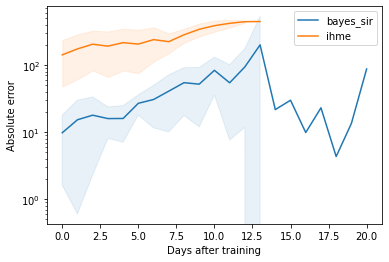

In [170]:
for model in predictions_relative:
    std = predictions_relative[model].std(axis = 1)
    mean = predictions_relative[model].mean(axis = 1)
    interval = 1.96 * std / np.sqrt(predictions_relative[model].notna().sum(axis = 1))
    
    ax = mean.plot(label = model)
    plt.fill_between(mean.index, mean + interval, mean - interval, color = ax.get_lines()[-1].get_color(), alpha=.1)
plt.xlabel("Days after training")
plt.ylabel("Absolute error")
plt.yscale('log')
plt.legend()
plt.show()

# Prediction for x days 

What is the average error for the following x days ?

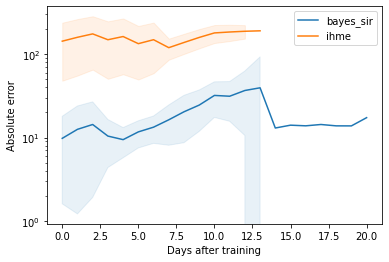

In [171]:
for model in predictions_relative:
    mean_matrix = predictions_relative[model].rolling(len(predictions_relative[model]), min_periods=1).mean()
    mean_matrix[predictions_relative[model].isnull()] = np.nan
    std = mean_matrix.std(axis = 1)
    mean = mean_matrix.mean(axis = 1)
    interval = 1.96 * std / np.sqrt(mean_matrix.notna().sum(axis = 1))
    
    ax = mean.plot(label = model)
    plt.fill_between(mean.index, mean + interval, mean - interval, color = ax.get_lines()[-1].get_color(), alpha=.1)
plt.xlabel("Days after training")
plt.ylabel("Absolute error")
plt.yscale('log')
plt.legend()
plt.show()

# Prediction for given date

What is the predictions that my model does for a given date ? Large variance indicates that the model changed 

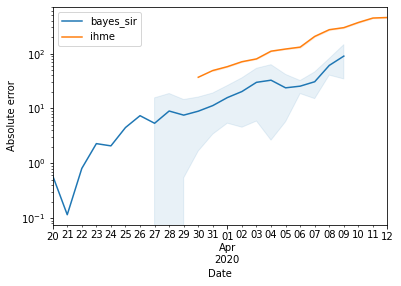

In [172]:
for model in predictions:
    std = predictions[model].std(axis = 1)
    mean = predictions[model].mean(axis = 1)
    interval = 1.96 * std / np.sqrt(predictions[model].notna().sum(axis = 1))
    
    ax = mean.plot(label = model)
    plt.fill_between(mean.index, mean + interval, mean - interval, color = ax.get_lines()[-1].get_color(), alpha=.1)
    
plt.xlabel("Date")
plt.ylabel("Absolute error")
plt.yscale('log')
plt.legend()
plt.show()

# Prediction until given date

What is the average error until a given date ?

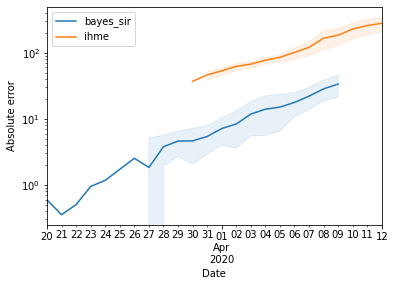

In [173]:
for model in predictions:
    mean_matrix = predictions[model].rolling(len(predictions[model]), min_periods=1).mean()
    mean_matrix[predictions[model].isnull()] = np.nan
    std = mean_matrix.std(axis = 1)
    mean = mean_matrix.mean(axis = 1)
    interval = 1.96 * std / np.sqrt(mean_matrix.notna().sum(axis = 1))
    
    ax = mean.plot(label = model)
    plt.fill_between(mean.index, mean + interval, mean - interval, color = ax.get_lines()[-1].get_color(), alpha=.1)
plt.xlabel("Date")
plt.ylabel("Absolute error")
plt.yscale('log')
plt.legend()
plt.show()

# Parameters

In [174]:
params = {}
for model in ['bayes_sir', 'sir_0', 'sir_100']:
    print(model)
    params[model] = {pd.to_datetime(f[8:-4]): pd.read_csv(os.path.join('params/', model,f), index_col = 'Parameter')['Value'] for f in os.listdir(os.path.join('params/', model)) if state in f}
    params[model] = pd.DataFrame({d: params[model][d] for d in sorted(params[model])}).T

bayes_sir
sir_0
sir_100


### Gamma

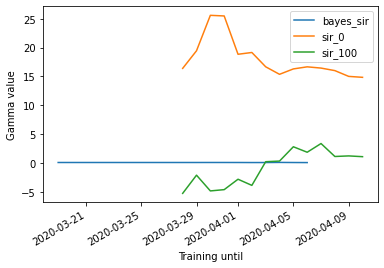

In [175]:
for model in params:
    params[model].gamma.plot(label = model)
plt.xlabel("Training until")
plt.ylabel("Gamma value")
plt.legend()
plt.show()

### Mortality

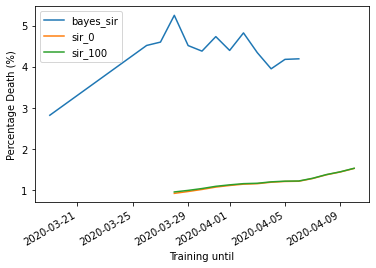

In [176]:
for model in params:
    (params[model].DeathProportion * 100).plot(label = model)
plt.xlabel("Training until")
plt.ylabel("Percentage Death (%)")
plt.legend()
plt.show()